# Settings

## Constant

In [1]:
import pytz
import os


DEFAULT_TZ = pytz.FixedOffset(540)  # GMT+09:00; Asia/Seoul

PATH_DATA = '../data'
PATH_ESM = os.path.join(PATH_DATA, 'EsmResponse.csv')
PATH_PARTICIPANT = os.path.join(PATH_DATA, 'UserInfo.csv')
PATH_SENSOR = os.path.join(PATH_DATA, 'Sensor')

PATH_INTERMEDIATE = './intermediate'

DATA_TYPES = {
    'Acceleration': 'ACC',
    'AmbientLight': 'AML',
    'Calorie': 'CAL',
    'Distance': 'DST',
    'EDA': 'EDA',
    'HR': 'HRT',
    'RRI': 'RRI',
    'SkinTemperature': 'SKT',
    'StepCount': 'STP',
    'UltraViolet': 'ULV',
    'ActivityEvent': 'ACE',
    'ActivityTransition': 'ACT',
    'AppUsageEvent': 'APP',
    'BatteryEvent': 'BAT',
    'CallEvent': 'CAE',
    'Connectivity': 'CON',
    'DataTraffic': 'DAT',
    'InstalledApp': 'INS',
    'Location': 'LOC',
    'MediaEvent': 'MED',
    'MessageEvent': 'MSG',
    'WiFi': 'WIF',
    'ScreenEvent': 'SCR',
    'RingerModeEvent': 'RNG',
    'ChargeEvent': 'CHG',
    'PowerSaveEvent': 'PWS',
    'OnOffEvent': 'ONF'
}


## Utility Functions

In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import cloudpickle
import ray
from datetime import datetime
from contextlib import contextmanager
import warnings
import time


def load(path: str):
    with open(path, mode='rb') as f:
        return cloudpickle.load(f)

    
def dump(obj, path: str):
    with open(path, mode='wb') as f:
        cloudpickle.dump(obj, f)
        
    
def log(msg: any):
    print('[{}] {}'.format(datetime.now().strftime('%y-%m-%d %H:%M:%S'), msg))


def summary(x):
    x = np.asarray(x)
    with warnings.catch_warnings():
        warnings.simplefilter('ignore')

        n = len(x)
        # Here, uppercase np.dtype.kind corresponds to non-numeric data.
        # Also, we view the boolean data as dichotomous categorical data.
        if x.dtype.kind.isupper() or x.dtype.kind == 'b': 
            cnt = pd.Series(x).value_counts(dropna=False)
            card = len(cnt)
            cnt = cnt[:20]                
            cnt_str = ', '.join([f'{u}:{c}' for u, c in zip(cnt.index, cnt)])
            if card > 30:
                cnt_str = f'{cnt_str}, ...'
            return {
                'n': n,
                'cardinality': card,
                'value_count': cnt_str
            }
        else: 
            x_nan = x[np.isnan(x)]
            x_norm = x[~np.isnan(x)]
            
            tot = np.sum(x_norm)
            m = np.mean(x_norm)
            me = np.median(x_norm)
            s = np.std(x_norm, ddof=1)
            l, u = np.min(x_norm), np.max(x)
            conf_l, conf_u = st.t.interval(0.95, len(x_norm) - 1, loc=m, scale=st.sem(x_norm))
            n_nan = len(x_nan)
            
            return {
                'n': n,
                'sum': tot,
                'mean': m,
                'SD': s,
                'med': me,
                'range': (l, u),
                'conf.': (conf_l, conf_u),
                'nan_count': n_nan
            }


@contextmanager
def on_ray(*args, **kwargs):
    try:
        if ray.is_initialized():
            ray.shutdown()
        ray.init(*args, **kwargs)
        yield None
    finally:
        ray.shutdown()

## Settings for R

In [3]:
%load_ext rpy2.ipython

In [4]:
%%R

library(tidyverse)
library(ggforce)
library(ggpubr)
library(showtext)
library(rmcorr)
library(patchwork)

# font_add_google(
#     name='Source Serif Pro',
#     family='ssp',
#     db_cache=FALSE
# )

showtext_auto()

THEME_DEFAULT <- theme_bw(
    base_size=10,
    base_family='ssp',
) + theme(
        axis.title.x=element_text(colour='grey20', size=10, face='bold'),
        axis.title.y=element_text(colour='grey20', size=10, face='bold'),
        axis.text.x=element_text(colour='grey20', size=10),
        axis.text.y=element_text(colour='grey20', size=10),
        strip.text.x=element_text(colour='grey20', size=10, face='bold'),
        strip.text.y=element_text(colour='grey20', size=10, face='bold'),
        legend.background=element_blank(),
        legend.title=element_text(colour='grey20', size=10, face='bold'),
        legend.text=element_text(colour='grey20', size=10),
        legend.position='top',
        legend.box.spacing= unit(0, 'cm'),
        plot.subtitle=element_text(colour='grey20', size=10, hjust=.5),
    )


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


R[write to console]: 필요한 패키지를 로딩중입니다: sysfonts

R[write to console]: 필요한 패키지를 로딩중입니다: showtextdb



# Dataset Overview

## Participants

In [5]:
import pandas as pd
import os


PARTICIPANTS = pd.read_csv(PATH_PARTICIPANT).set_index('pcode').assign(
    particpationStartDateTime=lambda x: pd.to_datetime(
        x['participationStartDate'], format='%Y-%m-%d'
    ).dt.tz_localize(DEFAULT_TZ)
)
PARTICIPANTS.head()

,participationStartDate,age,gender,openness,conscientiousness,neuroticism,extraversion,agreeableness,PSS,PHQ,GHQ,particpationStartDateTime
pcode,,,,,,,,,,,,
P01,2019-05-08,27,M,11,11,3,4,13,13,0,1,2019-05-08 00:00:00+09:00
P02,2019-05-08,21,M,14,5,12,14,5,27,6,18,2019-05-08 00:00:00+09:00
P03,2019-05-08,24,F,10,15,8,7,11,18,2,6,2019-05-08 00:00:00+09:00
P04,2019-05-08,23,M,12,11,8,6,11,20,1,9,2019-05-08 00:00:00+09:00
P05,2019-05-08,27,F,10,11,13,10,6,25,14,9,2019-05-08 00:00:00+09:00


Belows are some demographics:

In [6]:
for c in PARTICIPANTS.columns:
    print(f'- {c}:', summary(PARTICIPANTS[c]))

- participationStartDate: {'n': 77, 'cardinality': 3, 'value_count': '2019-05-08:27, 2019-05-16:25, 2019-04-30:25'}
- age: {'n': 77, 'sum': 1686, 'mean': 21.896103896103895, 'SD': 3.8613619617422406, 'med': 21.0, 'range': (17, 38), 'conf.': (21.01968223607122, 22.77252555613657), 'nan_count': 0}
- gender: {'n': 77, 'cardinality': 2, 'value_count': 'M:53, F:24'}
- openness: {'n': 77, 'sum': 787, 'mean': 10.220779220779221, 'SD': 2.8956563505732467, 'med': 11.0, 'range': (3, 15), 'conf.': (9.563545847995773, 10.87801259356267), 'nan_count': 0}
- conscientiousness: {'n': 77, 'sum': 820, 'mean': 10.64935064935065, 'SD': 2.3662441579221882, 'med': 11.0, 'range': (5, 15), 'conf.': (10.112279104782713, 11.186422193918586), 'nan_count': 0}
- neuroticism: {'n': 77, 'sum': 618, 'mean': 8.025974025974026, 'SD': 2.6900108881310953, 'med': 8.0, 'range': (3, 14), 'conf.': (7.4154164477308075, 8.636531604217245), 'nan_count': 0}
- extraversion: {'n': 77, 'sum': 703, 'mean': 9.12987012987013, 'SD': 3.

## Labels (via ESM)

In [7]:
import pandas as pd
import os


LABELS = pd.read_csv(PATH_ESM).set_index(
    ['pcode']
)
LABELS.head()

,responseTime,scheduledTime,valence,arousal,attention,stress,duration,disturbance,change
pcode,,,,,,,,,
P01,1557278103000,NaN,0,0,0,-1,20.0,3,-2
P01,1557278986000,1.557279e+12,-3,3,3,3,5.0,-1,-3
P01,1557281772000,1.557282e+12,-3,-2,2,2,15.0,3,-2
P01,1557287138000,NaN,2,-1,2,0,15.0,1,-1
P01,1557291117000,NaN,3,3,3,-3,20.0,1,0


In [8]:
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048), 'nan_count': 0}
- scheduledTime: {'n': 5582, 'sum': 5175814282500000.0, 'mean': 1557572760306.9517, 'SD': 591697484.8543198, 'med': 1557565860000.0, 'range': (1556586120000.0, nan), 'conf.': (1557552635074.4736, 1557592885539.4297), 'nan_count': 2259}
- valence: {'n': 5582, 'sum': 3665, 'mean': 0.6565747044070226, 'SD': 1.4184297545899174, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.6193565182132938, 0.6937928906007513), 'nan_count': 0}
- arousal: {'n': 5582, 'sum': -529, 'mean': -0.09476890003582945, 'SD': 1.6675313128774563, 'med': 0.0, 'range': (-3, 3), 'conf.': (-0.13852326339835566, -0.051014536673303246), 'nan_count': 0}
- attention: {'n': 5582, 'sum': 2236, 'mean': 0.4005732712289502, 'SD': 1.6113242733571864, 'med': 1.0, 'range': (-3, 3), 'conf.': (0.35829372468

Belows are some demographics:

In [9]:
inst = LABELS.groupby('pcode').count().iloc[:, -1]
inst_sch = LABELS.loc[lambda x: ~x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
inst_vol = LABELS.loc[lambda x: x['scheduledTime'].isna(), :].groupby('pcode').count().iloc[:, -1]
resp_time = LABELS.assign(
    timestamp=lambda x: pd.to_datetime(x['responseTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
)
sam = np.concatenate([
    (resp_time.loc[p, 'timestamp'].array - resp_time.loc[p, 'timestamp'].array.shift(1)).dropna().total_seconds()
    for p in LABELS.index.unique()
])

print('- # Inst.:', summary(inst))
print('- # Inst. - Scheduled:', summary(inst_sch))
print('- # Inst. - Voluntary:', summary(inst_vol))
print('- Samp. period:', summary(sam))
for c in LABELS.columns:
    print(f'- {c}:', summary(LABELS[c]))

- # Inst.: {'n': 77, 'sum': 5582, 'mean': 72.49350649350649, 'SD': 16.02270048911147, 'med': 74.0, 'range': (20, 110), 'conf.': (68.85679957506535, 76.13021341194762), 'nan_count': 0}
- # Inst. - Scheduled: {'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
- # Inst. - Voluntary: {'n': 77, 'sum': 2259, 'mean': 29.337662337662337, 'SD': 16.297893300742235, 'med': 27.0, 'range': (2, 74), 'conf.': (25.6384943127028, 33.03683036262187), 'nan_count': 0}
- Samp. period: {'n': 5505, 'sum': 42240670.0, 'mean': 7673.146230699364, 'SD': 13193.471538029606, 'med': 3090.0, 'range': (1.0, 136446.0), 'conf.': (7324.548923384188, 8021.743538014541), 'nan_count': 0}
- responseTime: {'n': 5582, 'sum': 8694314195328000, 'mean': 1557562557385.8833, 'SD': 590915040.4254278, 'med': 1557562969500.0, 'range': (1556582982000, 1558545246000), 'conf.': (1557547052362.8618, 1557578062408.9048)

### Plot

In [10]:
data = LABELS.loc[
    :, lambda x: ~x.columns.isin(['responseTime', 'scheduledTime'])
]

/Users/idong-won/anaconda3/envs/ray-env/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


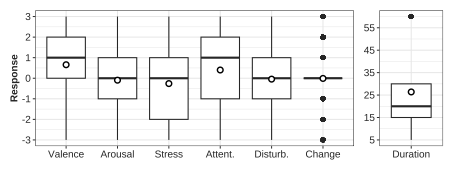

In [11]:
%%R -i data -w 16 -h 6 -u cm

data <- data %>% pivot_longer(
    cols = c('valence', 'arousal', 'attention', 'stress', 'duration', 'disturbance', 'change'),
    names_to = 'metric'
)

p_rest <- ggplot(
    data %>% filter(metric != 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric != 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
) + scale_x_discrete(
    name=NULL,
    limits=c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'),
    labels=c('Valence', 'Arousal', 'Stress', 'Attent.', 'Disturb.', 'Change'),
) + scale_y_continuous(
    name='Response',
    breaks=-3:3
) + THEME_DEFAULT

p_duration <- ggplot(
    data %>% filter(metric == 'duration'), aes(x=metric, y=value)
) + geom_boxplot(
) + geom_point(
    data = data %>% filter(
        metric == 'duration'
    ) %>% group_by(
        metric
    ) %>% summarise(
        mean = mean(value, na.rm=TRUE)
    ),
    mapping=aes(x=metric, y=mean),
    shape=21,
    stroke=1,
    size=2,
    fill='white'
)+ scale_x_discrete(
    name=NULL,
    limits=c('duration'),
    labels=c('Duration'),
) + scale_y_continuous(
    name=NULL,
    breaks=seq(from=5, to=60, by=10)
) + THEME_DEFAULT

p <- p_rest + p_duration + plot_layout(widths=c(4, 0.8))
ggsave('./fig/dist-labels.pdf', plot=p, width=16, height=6, unit='cm', device=cairo_pdf)
print(p)

### Correlation

Because each participant reported their labels multiple times (i.e., repeated measure), repeated measure correlation between affect labels were used.

In [12]:
data = LABELS.reset_index()[[
    'pcode', 'valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'
]]

In [13]:
%%R -i data 

com <- combn(c('valence', 'arousal', 'stress', 'attention', 'disturbance', 'change'), 2)

for(i in 1:ncol(com)) {
    a <- com[, i][1]
    b <- com[, i][2]
    r <- rmcorr(participant = 'pcode', measure1=a, measure2=b, dataset=data)
    cat(a, '-', b, ': R =', r$r, '(p =', r$p, ') \n')
}

valence - arousal : R = 0.3858505 (p = 6.005105e-195 ) 
valence - stress : R = -0.5918317 (p = 0 ) 
valence - attention : R = 0.2880379 (p = 1.138238e-105 ) 
valence - disturbance : R = -0.02946216 (p = 0.02880521 ) 
valence - change : R = 0.3163849 (p = 2.978458e-128 ) 
arousal - stress : R = -0.2020498 (p = 8.095612e-52 ) 
arousal - attention : R = 0.4354836 (p = 1.162341e-253 ) 
arousal - disturbance : R = 0.0284022 (p = 0.03507786 ) 
arousal - change : R = 0.1673468 (p = 7.1899e-36 ) 
stress - attention : R = -0.1515681 (p = 1.176714e-29 ) 
stress - disturbance : R = 0.08679844 (p = 1.108432e-10 ) 
stress - change : R = -0.2907816 (p = 9.560751e-108 ) 
attention - disturbance : R = 0.1182107 (p = 1.363257e-18 ) 
attention - change : R = 0.1163492 (p = 4.682081e-18 ) 
disturbance - change : R = -0.2216444 (p = 3.009815e-62 ) 


## Sensor Data

In [14]:
import os
import pandas as pd
from typing import Optional


def _load_data(
    name: str
) -> Optional[pd.DataFrame]:
    paths = [
        (d, os.path.join(PATH_SENSOR, d, f'{name}.csv'))
        for d in os.listdir(PATH_SENSOR)
        if d.startswith('P')
    ]
    return pd.concat(
        filter(
            lambda x: len(x.index), 
            [
                pd.read_csv(p).assign(pcode=pcode)
                for pcode, p in paths
                if os.path.exists(p)
            ]
        ), ignore_index=True
    ).assign(
        timestamp=lambda x: pd.to_datetime(x['timestamp'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ)
    ).set_index(
        ['pcode', 'timestamp']
    )

In [15]:
import pandas as pd
import gc
from datetime import timedelta as td


STATS = []

for data_type in DATA_TYPES:
    dat = _load_data(data_type)
    inst = dat.groupby('pcode').count().iloc[:, -1]
    samp = np.concatenate([
        (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
        for p in dat.index.get_level_values('pcode').unique()
    ])
    inst, samp = summary(inst), summary(samp)
    
    print('#'*5, data_type, '#'*5)
    print('- # Inst.:', inst)
    print('- Samp. period:', samp)
    
    for c in dat.columns:
        print(f'- {c}:', summary(dat[c]))
        
    del dat
    gc.collect()
    
STATS = pd.DataFrame(STATS)

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### Acceleration #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634806363, 1708233.8327261047), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.71600009, 'mean': 0.3343637686812146, 'SD': 113.32762322571307, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179495, 0.3543703520444797), 'nan_count': 0}
- x: {'n': 123260001, 'sum': -5999685.698486219, 'mean': -0.048675041780067964, 'SD': 0.6191499890392032, 'med': -0.066162109375, 'range': (-7.9951171875, 7.99975585938), 'conf.': (-0.048784344981250685, -0.04856573857888524), 'nan_count': 0}
- y: {'n': 123260001, 'sum': 21869550.39282226, 'mean': 0.17742617406616976, 'SD': 0.5751403091314404, 'med': 0.223876953125, 'range': (-7.9951171875, 7.9990234375), 'conf.': (0.17732464022456404, 0.17752770790777547), 'nan_count': 0}
- z: {'n': 123260001, 'sum': 27721322.122802734, 'mean': 0.22490119988

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### AmbientLight #####
- # Inst.: {'n': 77, 'sum': 31948974, 'mean': 414921.74025974027, 'SD': 122176.94279182944, 'med': 416936.0, 'range': (125402, 643940), 'conf.': (387190.9758092046, 442652.5047102759), 'nan_count': 0}
- Samp. period: {'n': 31948897, 'sum': 41213635.99199992, 'mean': 1.2899861923871712, 'SD': 222.60798183884265, 'med': 0.5, 'range': (0.001, 347544.869), 'conf.': (1.2127962165083053, 1.367176168266037), 'nan_count': 0}
- brightness: {'n': 31948974, 'sum': 11939891469, 'mean': 373.71752435618123, 'SD': 2573.66697101776, 'med': 39.0, 'range': (0, 65535), 'conf.': (372.82509879993745, 374.609949912425), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### Calorie #####
- # Inst.: {'n': 77, 'sum': 15601514, 'mean': 202617.06493506493, 'SD': 59660.549453893436, 'med': 203676.0, 'range': (61197, 314216), 'conf.': (189075.78123545274, 216158.34863467712), 'nan_count': 0}
- Samp. period: {'n': 15601437, 'sum': 41213542.377999984, 'mean': 2.6416504055363608, 'SD': 318.5582067426915, 'med': 1.025, 'range': (0.001, 347545.58), 'conf.': (2.4835785243545865, 2.799722286718135), 'nan_count': 0}
- caloriesToday: {'n': 15601514, 'sum': 17690514158, 'mean': 1133.897271636586, 'SD': 429.68944030674527, 'med': 1142.0, 'range': (0, 2387), 'conf.': (1133.684055812589, 1134.1104874605833), 'nan_count': 0}
- totalCalories: {'n': 15601514, 'sum': 90234460224, 'mean': 5783.6989553706135, 'SD': 3364.9152102294715, 'med': 5451.0, 'range': (0, 14838), 'conf.': (5782.029253716513, 5785.368657024714), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### Distance #####
- # Inst.: {'n': 77, 'sum': 15658461, 'mean': 203356.63636363635, 'SD': 64968.13128573705, 'med': 206892.0, 'range': (31, 319157), 'conf.': (188610.67935809953, 218102.59336917318), 'nan_count': 0}
- Samp. period: {'n': 15658384, 'sum': 41219633.380000025, 'mean': 2.632432144977414, 'SD': 318.256040768175, 'med': 1.009, 'range': (0.001, 347546.809), 'conf.': (2.4747976315300333, 2.790066658424795), 'nan_count': 0}
- motionType: {'n': 15658461, 'cardinality': 4, 'value_count': 'IDLE:14312951, WALKING:1312097, JOGGING:33213, RUNNING:200'}
- pace: {'n': 15658461, 'sum': 1729412434, 'mean': 110.4458754918507, 'SD': 366.6306708670267, 'med': 0.0, 'range': (0, 3225), 'conf.': (110.26428112155037, 110.62746986215103), 'nan_count': 0}
- speed: {'n': 15658461, 'sum': 187088259, 'mean': 11.948061753961644, 'SD': 36.67668738662746, 'med': 0.0, 'range': (0, 695), 'conf.': (11.929895570715365, 11.966227937207924), 'nan_count': 0}
- distanceToday: {'n': 15658461, 'sum': 39009999

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### EDA #####
- # Inst.: {'n': 77, 'sum': 80150329, 'mean': 1040913.3636363636, 'SD': 306422.1210160014, 'med': 1046093.0, 'range': (314771, 1615971), 'conf.': (971364.0733516462, 1110462.653921081), 'nan_count': 0}
- Samp. period: {'n': 80150252, 'sum': 41213631.25600018, 'mean': 0.5142046372605314, 'SD': 140.5468260735236, 'med': 0.199, 'range': (0.001, 347546.153), 'conf.': (0.4834354025951199, 0.5449738719259429), 'nan_count': 0}
- resistance: {'n': 80150329, 'sum': 4456740676426, 'mean': 55604.77083538858, 'SD': 121898.51318979551, 'med': 1385.0, 'range': (0, 340330), 'conf.': (55578.08419819559, 55631.45747258158), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### HR #####
- # Inst.: {'n': 77, 'sum': 13621023, 'mean': 176896.4025974026, 'SD': 52558.47787145981, 'med': 191711.0, 'range': (38545, 266374), 'conf.': (164967.09141619655, 188825.71377860865), 'nan_count': 0}
- Samp. period: {'n': 13620946, 'sum': 40968427.921000056, 'mean': 3.0077520255201113, 'SD': 362.91724584746083, 'med': 0.996, 'range': (0.001, 351677.643), 'conf.': (2.8150207922568913, 3.2004832587833314), 'nan_count': 0}
- bpm: {'n': 13621023, 'sum': 1029728342, 'mean': 75.59845850051057, 'SD': 9.820564496209332, 'med': 75.0, 'range': (35, 199), 'conf.': (75.59324319542789, 75.60367380559326), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### RRI #####
- # Inst.: {'n': 77, 'sum': 20764471, 'mean': 269668.45454545453, 'SD': 81037.2444152014, 'med': 279148.0, 'range': (81185, 439154), 'conf.': (251275.25624430407, 288061.652846605), 'nan_count': 0}
- Samp. period: {'n': 20764394, 'sum': 41213534.849999994, 'mean': 1.984817608931905, 'SD': 276.20029252330164, 'med': 0.762, 'range': (0.001, 347548.529), 'conf.': (1.866018654033734, 2.103616563830076), 'nan_count': 0}
- interval: {'n': 20764471, 'sum': 15700581045.231985, 'mean': 756.1271869257823, 'SD': 178.71396844200464, 'med': 763.232, 'range': (298.65599999999995, 1493.28), 'conf.': (756.0503188199684, 756.2040550315962), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### SkinTemperature #####
- # Inst.: {'n': 77, 'sum': 535095, 'mean': 6949.285714285715, 'SD': 2044.9192742858738, 'med': 7010.0, 'range': (2095, 10770), 'conf.': (6485.14597220523, 7413.4254563662), 'nan_count': 0}
- Samp. period: {'n': 535018, 'sum': 41212170.55199999, 'mean': 77.029502842895, 'SD': 1719.1916269814033, 'med': 30.082, 'range': (0.006, 347555.636), 'conf.': (72.42281097588155, 81.63619470990845), 'nan_count': 0}
- temperature: {'n': 535095, 'sum': 17310047.448570274, 'mean': 32.34948457483302, 'SD': 2.1008397544761457, 'med': 32.6599998474, 'range': (0.0, 41.1699981689), 'conf.': (32.3438556356817, 32.35511351398434), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### StepCount #####
- # Inst.: {'n': 77, 'sum': 15848456, 'mean': 205824.1038961039, 'SD': 60607.39763375781, 'med': 206903.0, 'range': (62164, 319175), 'conf.': (192067.91202113347, 219580.2957710743), 'nan_count': 0}
- Samp. period: {'n': 15848379, 'sum': 41213527.358, 'mean': 2.6004885015685204, 'SD': 316.071067601273, 'med': 1.009, 'range': (0.001, 347546.809), 'conf.': (2.4448774479214332, 2.7560995552156076), 'nan_count': 0}
- stepsToday: {'n': 15848456, 'sum': 51743117282, 'mean': 3264.8680276488763, 'SD': 2878.269178322283, 'med': 2686.0, 'range': (0, 20756), 'conf.': (3263.450974785182, 3266.2850805125704), 'nan_count': 0}
- totalSteps: {'n': 15848456, 'sum': 343389233538, 'mean': 21667.0465273084, 'SD': 15147.988032074709, 'med': 19338.0, 'range': (0, 93938), 'conf.': (21659.588746784702, 21674.5043078321), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### UltraViolet #####
- # Inst.: {'n': 77, 'sum': 264692, 'mean': 3437.5584415584417, 'SD': 1017.6239287455036, 'med': 3495.0, 'range': (1044, 5373), 'conf.': (3206.586141692076, 3668.5307414248073), 'nan_count': 0}
- Samp. period: {'n': 264615, 'sum': 41109668.71500001, 'mean': 155.3565319993198, 'SD': 2474.851673896092, 'med': 59.998, 'range': (0.012, 347610.692), 'conf.': (145.9269590786019, 164.7861049200377), 'nan_count': 0}
- intensity: {'n': 264692, 'cardinality': 4, 'value_count': 'NONE:260364, LOW:4301, MEDIUM:26, HIGH:1'}
- exposureToday: {'n': 264692, 'sum': 14238420000, 'mean': 53792.407779607995, 'SD': 193566.12706067282, 'med': 0.0, 'range': (0, 2220000), 'conf.': (53054.997767602305, 54529.817791613685), 'nan_count': 0}
- totalExposure: {'n': 264692, 'sum': 50604600000, 'mean': 191182.9598174482, 'SD': 362878.3346372806, 'med': 0.0, 'range': (0, 2700000), 'conf.': (189800.53758704624, 192565.38204785014), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### ActivityEvent #####
- # Inst.: {'n': 77, 'sum': 857437, 'mean': 11135.545454545454, 'SD': 4325.836148396645, 'med': 11085.0, 'range': (2640, 22938), 'conf.': (10153.70108570091, 12117.389823389998), 'nan_count': 0}
- Samp. period: {'n': 857360, 'sum': 43179845.23400003, 'mean': 50.36372729541853, 'SD': 631.3182326494629, 'med': 15.19, 'range': (0.001, 260838.132), 'conf.': (49.02739203647509, 51.70006255436196), 'nan_count': 0}
- confidenceStill: {'n': 857437, 'sum': 384491.5, 'mean': 0.4484195340299054, 'SD': 0.43461160263959403, 'med': 0.24, 'range': (0.0, 1.0), 'conf.': (0.44749961646725495, 0.4493394515925559), 'nan_count': 0}
- confidenceUnknown: {'n': 857437, 'sum': 77627.03000000001, 'mean': 0.09053380015091489, 'SD': 0.1544650548181326, 'med': 0.01, 'range': (0.0, 1.0), 'conf.': (0.09020685278945476, 0.09086074751237502), 'nan_count': 0}
- confidenceOnFoot: {'n': 857437, 'sum': 141488.60000000003, 'mean': 0.16501340623276117, 'SD': 0.30429163345470095, 'med': 0.01, 'range

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### ActivityTransition #####
- # Inst.: {'n': 77, 'sum': 51009, 'mean': 662.4545454545455, 'SD': 344.9931938861276, 'med': 608.0, 'range': (232, 2394), 'conf.': (584.1506954965814, 740.7583954125096), 'nan_count': 0}
- Samp. period: {'n': 50932, 'sum': 42154858.737, 'mean': 827.6694168106495, 'SD': 4482.627081784924, 'med': 0.0, 'range': (0.0, 261515.903), 'conf.': (788.7384080176117, 866.6004256036873), 'nan_count': 0}
- transitionType: {'n': 51009, 'cardinality': 10, 'value_count': 'EXIT_WALKING:11158, ENTER_WALKING:11151, ENTER_STILL:10419, EXIT_STILL:10414, ENTER_IN_VEHICLE:2441, EXIT_IN_VEHICLE:2431, EXIT_ON_BICYCLE:1170, ENTER_ON_BICYCLE:1169, ENTER_RUNNING:328, EXIT_RUNNING:328'}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### AppUsageEvent #####
- # Inst.: {'n': 77, 'sum': 1404657, 'mean': 18242.2987012987, 'SD': 7252.845122441942, 'med': 16956.0, 'range': (5179, 38243), 'conf.': (16596.10478703991, 19888.49261555749), 'nan_count': 0}
- Samp. period: {'n': 1404580, 'sum': 43369161.53999999, 'mean': 30.87696075695225, 'SD': 518.8103586669806, 'med': 0.379, 'range': (0.0, 260988.331), 'conf.': (30.01896752134943, 31.73495399255507), 'nan_count': 0}
- name: {'n': 1404657, 'cardinality': 873, 'value_count': '카카오톡:485233, 안드로이드 시스템:109284, Samsung Experience 홈:94274, One UI 홈:47717, Facebook:47637, 기본홈:47156, Paco:42692, 시스템 UI:28225, 트위터:24874, Chrome:19664, Polar Beat:19492, 캐시워크:17301, 네이버 웹툰:16860, 삼성 인터넷:16780, Instagram:13360, 설정:13134, YouTube:12091, 메시지:11815, 시계:10724, 디시인사이드:10693, ...'}
- packageName: {'n': 1404657, 'cardinality': 883, 'value_count': 'com.kakao.talk:485233, com.sec.android.app.launcher:150200, android:118565, com.facebook.katana:47637, com.lge.launcher3:46200, com.pacoapp.paco:4

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### BatteryEvent #####
- # Inst.: {'n': 77, 'sum': 1160326, 'mean': 15069.16883116883, 'SD': 7677.663567303528, 'med': 12795.0, 'range': (2872, 42124), 'conf.': (13326.552957418293, 16811.78470491937), 'nan_count': 0}
- Samp. period: {'n': 1160249, 'sum': 43417685.227000006, 'mean': 37.42100637621753, 'SD': 425.2680918274714, 'med': 10.168, 'range': (0.001, 261248.657), 'conf.': (36.6471938757714, 38.19481887666365), 'nan_count': 0}
- status: {'n': 1160326, 'cardinality': 4, 'value_count': 'CHARGING:651709, DISCHARGING:423437, FULL:81850, NOT_CHARGING:3330'}
- temperature: {'n': 1160326, 'sum': 37831986.300000004, 'mean': 32.6046182710721, 'SD': 4.162447912169572, 'med': 32.7, 'range': (9.7, 81.3), 'conf.': (32.59704458422733, 32.61219195791686), 'nan_count': 0}
- level: {'n': 1160326, 'sum': 73058432.0, 'mean': 62.963711922339066, 'SD': 28.00723752388256, 'med': 66.0, 'range': (0.0, 100.0), 'conf.': (62.912751994222575, 63.01467185045556), 'nan_count': 0}
- plugged: {'n': 1160326, '

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### Connectivity #####
- # Inst.: {'n': 77, 'sum': 40304, 'mean': 523.4285714285714, 'SD': 352.0607538992243, 'med': 472.0, 'range': (39, 1686), 'conf.': (443.5205821175942, 603.3365607395488), 'nan_count': 0}
- Samp. period: {'n': 40227, 'sum': 41337347.348, 'mean': 1027.60204211102, 'SD': 5936.1155714691295, 'med': 6.436, 'range': (0.004, 296303.731), 'conf.': (969.5917992410127, 1085.6122849810272), 'nan_count': 0}
- isConnected: {'n': 40304, 'cardinality': 2, 'value_count': 'False:31289, True:9015'}
- type: {'n': 40304, 'cardinality': 5, 'value_count': 'WIFI:20614, MOBILE:18815, UNDEFINED:752, VPN:107, MOBILE_DUN:16'}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### DataTraffic #####
- # Inst.: {'n': 77, 'sum': 692935, 'mean': 8999.155844155845, 'SD': 3664.6841935630578, 'med': 8428.0, 'range': (1584, 19668), 'conf.': (8167.374561737846, 9830.937126573843), 'nan_count': 0}
- Samp. period: {'n': 692858, 'sum': 43067429.30399998, 'mean': 62.15909941719657, 'SD': 807.6512193118494, 'med': 15.033, 'range': (11.534, 261869.448), 'conf.': (60.257361853764074, 64.06083698062906), 'nan_count': 0}
- rxKiloBytes: {'n': 692935, 'sum': 937801669, 'mean': 1353.3761016545564, 'SD': 9590.34510007972, 'med': 40.0, 'range': (0, 847233), 'conf.': (1330.795431037939, 1375.9567722711738), 'nan_count': 0}
- txKiloBytes: {'n': 692935, 'sum': 186407124, 'mean': 269.0109808279276, 'SD': 8837.797315547426, 'med': 11.0, 'range': (0, 844800), 'conf.': (248.20219990542003, 289.81976175043513), 'nan_count': 0}


/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### InstalledApp #####
- # Inst.: {'n': 77, 'sum': 1635350, 'mean': 21238.31168831169, 'SD': 5286.182229120261, 'med': 21459.0, 'range': (4046, 31192), 'conf.': (20038.495496412797, 22438.12788021058), 'nan_count': 0}
- Samp. period: {'n': 1635273, 'sum': 42803911.34099997, 'mean': 26.175391718080082, 'SD': 631.0867933465357, 'med': 0.0, 'range': (0.0, 271385.388), 'conf.': (25.208133627055034, 27.14264980910513), 'nan_count': 0}
- name: {'n': 1635350, 'cardinality': 3307, 'value_count': '전화:10225, 소프트웨어 업데이트:9364, 설정:7278, SmartThings:4777, 캘린더:4585, 메시지:3970, com.android.wallpapercropper:3916, Google One Time Init:3916, HTML 뷰어:3916, ABC Logger:3916, 외부 저장소:3916, YouTube:3916, MmsService:3915, 패키지 액세스 도움말:3915, AhnLab V3 Mobile Plus 2.0:3915, Google Play 스토어:3915, Polar Beat:3915, ConfigUpdater:3915, PacProcessor:3915, Gmail:3914, ...'}
- lastUpdateTime: {'n': 1635350, 'cardinality': 15829, 'value_count': '1230735600000:509400, 1230735600000:22951, 1217592000000:18601, 148188542200

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### Location #####
- # Inst.: {'n': 77, 'sum': 788430, 'mean': 10239.35064935065, 'SD': 5938.968016340164, 'med': 8854.0, 'range': (2047, 27742), 'conf.': (8891.370258148654, 11587.331040552646), 'nan_count': 0}
- Samp. period: {'n': 788353, 'sum': 42733537.06000001, 'mean': 54.206094300395904, 'SD': 888.3962695759783, 'med': 2.0, 'range': (0.001, 261313.101), 'conf.': (52.24501515308692, 56.16717344770489), 'nan_count': 0}
- altitude: {'n': 788430, 'sum': 58369986.846610546, 'mean': 74.03318854763333, 'SD': 41.098040946809455, 'med': 75.82608032225, 'range': (-971.050583942, 4929.0), 'conf.': (73.94247162532992, 74.12390546993674), 'nan_count': 0}
- longitude: {'n': 788430, 'sum': 27067830.23711562, 'mean': 34.33130428461071, 'SD': 0.7948267295443734, 'med': 34.317752, 'range': (-243.2547574, 96.4067178), 'conf.': (34.329549840043335, 34.333058729178084), 'nan_count': 0}
- latitude: {'n': 788430, 'sum': 28759191.682146598, 'mean': 36.4765314386142, 'SD': 0.4377095808569027, 'med': 3

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### MessageEvent #####
- # Inst.: {'n': 66, 'sum': 2591, 'mean': 39.25757575757576, 'SD': 61.801247337688686, 'med': 22.0, 'range': (1, 442), 'conf.': (24.06493292447739, 54.450218590674126), 'nan_count': 0}
- Samp. period: {'n': 2525, 'sum': 21158724.134999998, 'mean': 8379.692726732672, 'SD': 25685.474909155768, 'med': 302.559, 'range': (0.042, 426967.0), 'conf.': (7377.356768788159, 9382.028684677185), 'nan_count': 0}
- messageBox: {'n': 2591, 'cardinality': 2, 'value_count': 'INBOX:1758, SENT:833'}
- isPinned: {'n': 2591, 'cardinality': 2, 'value_count': 'False:2536, True:55'}
- timesContacted: {'n': 2591, 'sum': 50100, 'mean': 19.336163643380935, 'SD': 147.65114917889434, 'med': 1.0, 'range': (0, 2466), 'conf.': (13.64823398009501, 25.02409330666686), 'nan_count': 0}
- number: {'n': 2591, 'cardinality': 383, 'value_count': '0104$070dd33ca6bb9f397ef5d50b5ff85a68:335, 0105$5539bf1719ca24553f5cdc026780ab6d:257, 0104$fab8457f6f6fe2575d1ba5205177cbee:167, 0104$6562f5252e190f86894d5b5

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### WiFi #####
- # Inst.: {'n': 77, 'sum': 15258102, 'mean': 198157.16883116882, 'SD': 147795.70290664234, 'med': 178686.0, 'range': (28475, 900435), 'conf.': (164611.65909379855, 231702.6785685391), 'nan_count': 0}
- Samp. period: {'n': 15258025, 'sum': 43178434.54100005, 'mean': 2.8298835885378386, 'SD': 148.96371508723632, 'med': 0.0, 'range': (0.0, 260934.687), 'conf.': (2.755139050978291, 2.904628126097386), 'nan_count': 0}
- bssid: {'n': 15258102, 'cardinality': 310874, 'value_count': '6b186e57-cc96-4f85-ad3c-80734ba597b8:20300, 777ae97a-7584-4414-9862-ee8a4645ae8b:15749, 6dd66e08-a0b7-481e-af4b-9d70e82d49cb:15458, adab9bd0-15e5-409f-929c-57f4f0424c50:15331, bdb0522c-5453-4e8f-8bb9-93b2483cced5:13912, 454820e6-9e3b-4938-9cf6-74a955c47e05:13777, 2fac2da8-d0f8-408d-9608-b98caa359823:13745, 14e48f9a-2b95-4f53-9ee4-90add0183eb0:13287, da75aa19-6ec8-490f-8830-fd62fd315af9:13186, fd5ba903-8eea-4771-af9d-86f84f037d8b:13170, 87b30ad2-34b8-49c7-b150-c057943d8b22:12703, b5d5d05d-6a0a-468

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### ScreenEvent #####
- # Inst.: {'n': 77, 'sum': 207137, 'mean': 2690.090909090909, 'SD': 998.2933091534162, 'med': 2718.0, 'range': (512, 5034), 'conf.': (2463.506121682638, 2916.67569649918), 'nan_count': 0}
- Samp. period: {'n': 207060, 'sum': 43288647.885, 'mean': 209.06330476673426, 'SD': 1404.1554471892762, 'med': 13.744499999999999, 'range': (0.003, 261385.771), 'conf.': (203.01522216468575, 215.11138736878277), 'nan_count': 0}
- type: {'n': 207137, 'cardinality': 3, 'value_count': 'ON:77317, OFF:77233, UNLOCK:52587'}
##### RingerModeEvent #####
- # Inst.: {'n': 76, 'sum': 1242, 'mean': 16.342105263157894, 'SD': 15.946203419898165, 'med': 11.5, 'range': (1, 87), 'conf.': (12.698241687470867, 19.98596883884492), 'nan_count': 0}
- Samp. period: {'n': 1166, 'sum': 30162187.283999998, 'mean': 25868.08514922813, 'SD': 46793.84456857768, 'med': 5975.3595000000005, 'range': (0.013, 434379.337), 'conf.': (23179.40601877253, 28556.764279683728), 'nan_count': 0}
- type: {'n': 1242, 'ca

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()
/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/1897082983.py:12: PerformanceWarning: indexing past lexsort depth may impact performance.
  (dat.loc[(p,), :].index.array - dat.loc[(p,), :].index.array.shift(1)).dropna().total_seconds()


##### PowerSaveEvent #####
- # Inst.: {'n': 16, 'sum': 370, 'mean': 23.125, 'SD': 62.0127675026146, 'med': 4.0, 'range': (1, 254), 'conf.': (-9.919271278080963, 56.16927127808096), 'nan_count': 0}
- Samp. period: {'n': 354, 'sum': 3364281.0879999995, 'mean': 9503.618892655366, 'SD': 27354.303418008072, 'med': 283.078, 'range': (0.008, 347353.123), 'conf.': (6644.292754534579, 12362.945030776153), 'nan_count': 0}
- type: {'n': 370, 'cardinality': 2, 'value_count': 'ACTIVATE:211, DEACTIVATE:159'}
##### OnOffEvent #####
- # Inst.: {'n': 47, 'sum': 184, 'mean': 3.9148936170212765, 'SD': 2.857711057548792, 'med': 3.0, 'range': (1, 16), 'conf.': (3.0758382173535552, 4.753949016688997), 'nan_count': 0}
- Samp. period: {'n': 137, 'sum': 7283051.445, 'mean': 53160.95945255474, 'SD': 87596.26514794471, 'med': 5687.382, 'range': (84.24, 429360.778), 'conf.': (38361.18334128552, 67960.73556382397), 'nan_count': 0}
- type: {'n': 184, 'cardinality': 2, 'value_count': 'ON:95, OFF:89'}


# Preprocessing

## Label

Because we intended to collected participants' responses to ESMs not voluntary responses, we screend out some responses as follows:
* We first screen out ESM responses that does not have 'scheduledTime' (meaning that a given ESM was expired or participants voluntarily reported their affective states regardless of ESM delivery). 
* Since we will evaluate our model using LOSO, the small number of responses for each participant might lead to inappropriate performance evaluation. We emprically set the number of the minimum responses upon ESM delivery as 5 per day (i.e., a half of our guides), so that we excluded participants whose responses to ESM less than 35.

In [16]:
LABELS_VALID = LABELS.loc[
    lambda x: ~x['scheduledTime'].isna(), :
]
print(f'# Non-voluntary response: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

excl_pcode = LABELS_VALID.loc[
    lambda x: ~x['scheduledTime'].isna()
].groupby('pcode').count().iloc[:, -1].loc[lambda y: y < 35]

LABELS_VALID = LABELS_VALID.loc[
    lambda x:  ~x.index.get_level_values('pcode').isin(excl_pcode.index), :
]
print(f'# Response from participants with enough responses: {len(LABELS_VALID)}')
print(summary(LABELS_VALID.groupby('pcode').count().iloc[:, -1]))

print('# Participants whose responses to ESM delivery were less then 35')
print(excl_pcode, f'#participants = {len(excl_pcode)} / #response = {sum(excl_pcode)}')

# Non-voluntary response: 3323
{'n': 76, 'sum': 3323, 'mean': 43.723684210526315, 'SD': 19.36291898394835, 'med': 43.5, 'range': (3, 83), 'conf.': (39.29906768289902, 48.14830073815361), 'nan_count': 0}
# Response from participants with enough responses: 2619
{'n': 47, 'sum': 2619, 'mean': 55.723404255319146, 'SD': 13.076201628480542, 'med': 52.0, 'range': (36, 83), 'conf.': (51.88408762653044, 59.562720884107854), 'nan_count': 0}
# Participants whose responses to ESM delivery were less then 35
pcode
P04    34
P07    24
P11    22
P14    11
P16    30
P17    13
P18    32
P20    31
P22    23
P24    10
P25    30
P29    32
P34    22
P36    29
P37    31
P38    33
P41    31
P43    24
P44    23
P46     4
P54    13
P56    31
P58    29
P62     3
P63    34
P64    30
P68    11
P73    31
P74    33
Name: change, dtype: int64 #participants = 29 / #response = 704


Here we consider binary classifications for valence, arousal, stress, and disturbance, in which a label value greater than 0 is "HIGH" (1) and the rest is "LOW" (0), at the arrival of ESM prompts (*scheduledTime*)

In [17]:
import pandas as pd
import numpy as np

LABELS_PROC = (
    LABELS_VALID
    .reset_index()
    .assign(
        timestamp=lambda x: pd.to_datetime(x['scheduledTime'], unit='ms', utc=True).dt.tz_convert(DEFAULT_TZ),
        attention_bin=lambda x: np.where(x['attention'] > 0, 1, 0)
    )
    .loc[:, ['pcode', 'timestamp', 'attention', 'attention_bin']]  # attention: 연속형, attention_bin: 이진분류된 데이터
    .set_index(['pcode', 'timestamp'])
)

LABELS_PROC.head()

attention  attention_bin
pcode timestamp                                          
P01   2019-05-08 10:26:00+09:00          3              1
      2019-05-08 11:13:00+09:00          2              1
      2019-05-08 15:56:00+09:00          3              1
      2019-05-08 16:41:00+09:00          3              1
      2019-05-08 17:23:00+09:00          3              1

In [18]:
import numpy as np


inst = LABELS_PROC.groupby('pcode').count().iloc[:, -1]
for c in [c for c in LABELS_PROC.columns if c.endswith('_bin')]:
    print(f'- {c}:', summary(LABELS_PROC[c].astype(object)))

- attention_bin: {'n': 2619, 'cardinality': 2, 'value_count': '0:1312, 1:1307'}


## Sensor Data

For each type of sensor data, we applied different preprocessing. Detailed decsription is provided in the paper.



### Implementation

In [19]:
import pandas as pd
import numpy as np
import scipy.spatial.distance as dist
from typing import Dict, Union
import pygeohash as geo
from datetime import timedelta
from collections import defaultdict


# AppUsageEvent.csv
def _proc_app_usage(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['type'].isin(['MOVE_TO_FOREGROUND', 'MOVE_TO_BACKGROUND']), :
    ].assign(
        packageName=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['packageName'], None),
        category=lambda x: np.where(x['type'] == 'MOVE_TO_FOREGROUND', x['category'], None),
    )

    return {
        'PAC': data['packageName'].astype('object'),
        'CAT': data['category'].astype('object')
    }


# Connectivity.csv
def _proc_connectivity(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        type=lambda x: np.where(x['isConnected'] == True, x['type'], 'DISCONNECTED')
    )

    return data['type'].astype('object')


# BatteryEvent.csv
def _proc_battery(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'LEV': data['level'].astype('float32'),
        'STA': data['status'].astype('object'),
        'TMP': data['temperature'].astype('float32')
    }
        

# CallEvent.csv
def _proc_call(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['duration'] > 0, :
    ]
    new_data = []

    for row in data.itertuples():
        pcode, timestamp = row.Index
        
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp,                
            'state': 'CALL',
        })
        new_data.append({
            'pcode': pcode,
            'timestamp': timestamp + timedelta(milliseconds=row.duration),
            'state': 'IDLE'
        })

    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['state'].astype('object')


# DataTraffic.csv
def _proc_data_traffic(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'RCV': data['rxKiloBytes'].astype('float32'),
        'SNT': data['txKiloBytes'].astype('float32')
    }


# RingerModeEvent.csv
def _proc_ringer_mode(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ScreenEvent.csv
def _proc_screen(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# OnOffEvent.csv
def _proc_on_off(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# PowerSaveEvent.csv
def _proc_power_save(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# ChargeEvent.csv
def _proc_charge(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['type'].astype('object')


# Location.csv
def _proc_location(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    def _haversine(_lat1, _lat2, _lng1, _lng2) -> float:
        if np.isnan(_lat1) or np.isnan(_lat2) or np.isnan(_lng1) or np.isnan(_lng2):
            return 0.0

        _lat1_r, _lat2_r, _lng1_r, _lng2_r = np.radians(_lat1), np.radians(_lat2), np.radians(_lng1), np.radians(_lng2)
        _lat = _lat2_r - _lat1_r
        _lng = _lng2_r - _lng1_r
        _R = 6371008.8
        _d = np.sin(_lat * 0.5) ** 2 + np.cos(_lat1_r) * np.cos(_lat2_r) * np.sin(_lng * 0.5) ** 2
        return 2 * _R * np.arcsin(np.sqrt(_d))

    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            _latitude=lambda x: x['latitude'].shift(1),
            _longitude=lambda x: x['longitude'].shift(1),
            dist=lambda x: x.apply(
                lambda y: _haversine(y['latitude'], y['_latitude'], y['longitude'], y['_longitude']),
                axis=1
            ),
            cluster=lambda x: x.apply(
                lambda y: geo.encode(y['latitude'], y['longitude'], precision=7),
                axis=1
            ),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'CLS': new_data['cluster'].astype('object'),
        'DST': new_data['dist'].astype('float32')
    }


# ActivityEvent.csv
def _proc_activity_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return {
        'UNK': data['confidenceUnknown'].astype('float32'),
        'FOT': data['confidenceOnFoot'].astype('float32'),
        'WLK': data['confidenceWalking'].astype('float32'),
        'VHC': data['confidenceInVehicle'].astype('float32'),
        'BCC': data['confidenceOnBicycle'].astype('float32'),
        'RUN': data['confidenceRunning'].astype('float32'),
        'TLT': data['confidenceTilting'].astype('float32')
    }


# ActivityTransition.csv
def _proc_activity_transition(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.loc[
        lambda x: x['transitionType'].isin(['ENTER_WALKING', 'ENTER_STILL', 'ENTER_IN_VEHICLE', 'ENTER_ON_BICYCLE', 'ENTER_RUNNING']), :
    ].assign(
        type=lambda x: x['transitionType'].str.replace('ENTER_', '')
    )
    
    return data['type'].astype('object')


# WiFi.csv
def _proc_wifi(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            bssid=lambda x: x['bssid'].str.cat(x['frequency'].astype(str), sep='-')
        )
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['bssid'], cur['bssid'])
            union = np.union1d(prev['bssid'], cur['bssid'])
            w = np.repeat(1 / len(intersect), len(intersect)) if len(intersect) else 1.0
            prev_intersect = prev.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            cur_intersect = cur.loc[
                lambda x: x['bssid'].isin(intersect), :
            ].sort_values('bssid')
            prev_rssi = prev_intersect['rssi']
            cur_rssi = cur_intersect['rssi']

            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                cosine=1 - dist.cosine(prev_rssi, cur_rssi) if len(intersect) > 0 else 0,
                euclidean=1 / (1 + dist.euclidean(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                manhattan=1 / (1 + dist.cityblock(prev_rssi, cur_rssi, w)) if len(intersect) > 0 else 0,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
        'COS': new_data['cosine'].astype('float32'),
        'EUC': new_data['euclidean'].astype('float32'),
        'MAN': new_data['manhattan'].astype('float32'),
        'JAC': new_data['jaccard'].astype('float32')
    }


# InstalledApp.csv
def _proc_installed_app(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(axis=0, level='timestamp')
        t = sub.index.unique().array
        for cur_t, prev_t in zip(t, t.shift(1)):
            if cur_t is pd.NaT or prev_t is pd.NaT:
                continue

            prev = sub.loc[[prev_t], :]
            cur = sub.loc[[cur_t], :]
            intersect = np.intersect1d(prev['packageName'], cur['packageName'])
            union = np.union1d(prev['packageName'], cur['packageName'])
            new_data.append(dict(
                pcode=pcode,
                timestamp=cur_t,
                jaccard = len(intersect) / len(union) if len(union) > 0 else 0
            ))
            
    new_data = pd.DataFrame(new_data).set_index(
        ['pcode', 'timestamp']
    )
    
    return {
       'JAC': new_data['jaccard'].astype('float32')
    }


# MediaEvent.csv
def _proc_media_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        video = sub.loc[
            lambda x: x['mimetype'].str.startswith('video'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        image = sub.loc[
            lambda x: x['mimetype'].str.startswith('image'), :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        media = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['VID'].append(video)
        new_data['IMG'].append(image)
        new_data['ALL'].append(media)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# MessageEvent.csv
def _proc_message_event(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = defaultdict(list)
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        )

        sent = sub.loc[
            lambda x: x['messageBox'] == 'SENT', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        recv = sub.loc[
            lambda x: x['messageBox'] == 'INBOX', :
        ].assign(
            event=1,
            pcode=pcode
        ).reset_index()

        msg = sub.assign(
            event=1,
            pcode=pcode
        ).reset_index()

        new_data['SNT'].append(sent)
        new_data['RCV'].append(recv)
        new_data['ALL'].append(msg)

    return {
        k: pd.concat(
            v, axis=0, ignore_index=True
        ).set_index(
            ['pcode', 'timestamp']
        )['event'].astype('float32') 
        for k, v in new_data.items()
    }


# Acceleration.csv
def _proc_acceleration(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    data = data.assign(
        mag=lambda x: np.sqrt(np.square(x['x']) + np.square(x['y']) + np.square(x['z']))
    )

    return {
        'AXX': data['x'].astype('float32'),
        'AXY': data['y'].astype('float32'),
        'AXZ': data['z'].astype('float32'),
        'MAG': data['mag'].astype('float32')
    }

# UltraViolet.csv
def _proc_ultra_violet(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []
    
    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            exposure=lambda x: (x['totalExposure'] - x['totalExposure'].shift(1)),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'INT': new_data['intensity'].astype('object'),
        'EXP': new_data['exposure'].dropna().astype('float32')
    }


# SkinTemperature.csv
def _proc_skin_temperature(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['temperature'].astype('float32')


# RRI.csv
def _proc_rri(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['interval'].astype('float32')


# AmbientLight.csv
def _proc_ambient_light(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['brightness'].astype('float32')
    

# StepCount.csv
def _proc_step_count(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            steps=lambda x: (x['totalSteps'] - x['totalSteps'].shift(1)),
            pcode=pcode
        ).reset_index()
        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['steps'].dropna().astype('float32')
    

# HR.csv
def _proc_hr(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['bpm'].astype('float32')
    

# EDA.csv
def _proc_eda(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    return data['resistance'].astype('float32')


# Distance.csv
def _proc_distance(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            distance=lambda x: x['totalDistance'] - x['totalDistance'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return {
        'DST': new_data['distance'].dropna().astype('float32'),
        'MOT': new_data['motionType'].astype('object'),
        'PAC': new_data['pace'].astype('float32'),
        'SPD': new_data['speed'].astype('float32')
    }


# Calorie.csv
def _proc_calories(data: pd.DataFrame) -> Union[pd.Series, Dict[str, pd.Series]]:
    new_data = []

    for pcode in data.index.get_level_values('pcode').unique():
        sub = data.loc[(pcode, ), :].sort_index(
            axis=0, level='timestamp'
        ).assign(
            calories=lambda x: x['totalCalories'] - x['totalCalories'].shift(1),
            pcode=pcode
        ).reset_index()

        new_data.append(sub)

    new_data = pd.concat(new_data, axis=0, ignore_index=True).set_index(
        ['pcode', 'timestamp']
    )

    return new_data['calories'].dropna().astype('float32')           


### Execution

In [20]:
import pandas as pd
import gc
from functools import reduce

FUNC_PROC = {
    'Acceleration': _proc_acceleration,
    'AmbientLight': _proc_ambient_light,
    'Calorie': _proc_calories,
    'Distance': _proc_distance,
    'EDA': _proc_eda,
    'HR': _proc_hr,
    'RRI': _proc_rri,
    'SkinTemperature': _proc_skin_temperature,
    'StepCount': _proc_step_count,
    'UltraViolet': _proc_ultra_violet,
    'ActivityEvent': _proc_activity_event,
    'ActivityTransition': _proc_activity_transition,
    'AppUsageEvent': _proc_app_usage,
    'BatteryEvent': _proc_battery,
    'CallEvent': _proc_call,
    'Connectivity': _proc_connectivity,
    'DataTraffic': _proc_data_traffic,
    'InstalledApp': _proc_installed_app,
    'Location': _proc_location,
    'MediaEvent': _proc_media_event,
    'MessageEvent': _proc_message_event,
    'WiFi': _proc_wifi,
    'ScreenEvent': _proc_screen,
    'RingerModeEvent': _proc_ringer_mode,
    'ChargeEvent': _proc_charge,
    'PowerSaveEvent': _proc_power_save,
    'OnOffEvent': _proc_on_off
}


def _process(data_type: str):
    log(f'Begin to processing data: {data_type}')
    
    abbrev = DATA_TYPES[data_type]
    data_raw = _load_data(data_type)
    data_proc = FUNC_PROC[data_type](data_raw)
    result = dict()
    
    if type(data_proc) is dict:
        for k, v in data_proc.items():
            result[f'{abbrev}_{k}'] = v
    else:
        result[abbrev] = data_proc
        
    log(f'Complete processing data: {data_type}')
    return result



with on_ray(num_cpus=12):
    jobs = []
    
    func = ray.remote(_process).remote
    
    for data_type in DATA_TYPES:
        job = func(data_type)
        jobs.append(job)

    jobs = ray.get(jobs)
    jobs = reduce(lambda a, b: {**a, **b}, jobs)
    dump(jobs, os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

    del jobs
    gc.collect()

2025-05-12 17:43:17,264	INFO worker.py:1538 -- Started a local Ray instance.


(_process pid=3776) [25-05-12 17:43:18] Begin to processing data: Acceleration
(_process pid=3769) [25-05-12 17:43:19] Begin to processing data: ActivityTransition
(_process pid=3774) [25-05-12 17:43:19] Begin to processing data: ActivityEvent
(_process pid=3770) [25-05-12 17:43:19] Begin to processing data: RRI
(_process pid=3773) [25-05-12 17:43:19] Begin to processing data: HR
(_process pid=3779) [25-05-12 17:43:19] Begin to processing data: UltraViolet
(_process pid=3777) [25-05-12 17:43:19] Begin to processing data: StepCount
(_process pid=3778) [25-05-12 17:43:19] Begin to processing data: EDA
(_process pid=3780) [25-05-12 17:43:18] Begin to processing data: SkinTemperature
(_process pid=3772) [25-05-12 17:43:19] Begin to processing data: Distance
(_process pid=3775) [25-05-12 17:43:19] Begin to processing data: AmbientLight
(_process pid=3769) [25-05-12 17:43:19] Complete processing data: ActivityTransition
(_process pid=3769) [25-05-12 17:43:19] Begin to processing data: AppUsa

(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: in

(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:353: PerformanceWarning: in

(_process pid=3780) [25-05-12 17:43:19] Complete processing data: SkinTemperature
(_process pid=3780) [25-05-12 17:43:19] Begin to processing data: BatteryEvent
(_process pid=3779) [25-05-12 17:43:19] Complete processing data: UltraViolet
(_process pid=3779) [25-05-12 17:43:19] Begin to processing data: CallEvent
(_process pid=3779) [25-05-12 17:43:19] Complete processing data: CallEvent
(_process pid=3779) [25-05-12 17:43:20] Begin to processing data: Connectivity
(_process pid=3779) [25-05-12 17:43:20] Complete processing data: Connectivity
(_process pid=3779) [25-05-12 17:43:20] Begin to processing data: DataTraffic
(_process pid=3774) [25-05-12 17:43:20] Complete processing data: ActivityEvent
(_process pid=3774) [25-05-12 17:43:20] Begin to processing data: InstalledApp
(_process pid=3779) [25-05-12 17:43:21] Complete processing data: DataTraffic
(_process pid=3779) [25-05-12 17:43:21] Begin to processing data: Location
(_process pid=3780) [25-05-12 17:43:21] Complete processing d

(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: in

(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:256: PerformanceWarning: in

(_process pid=3780) [25-05-12 17:43:21] Complete processing data: MediaEvent
(_process pid=3780) [25-05-12 17:43:21] Begin to processing data: MessageEvent


(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: in

(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:298: PerformanceWarning: in

(_process pid=3780) [25-05-12 17:43:22] Complete processing data: MessageEvent
(_process pid=3780) [25-05-12 17:43:22] Begin to processing data: WiFi
(_process pid=3769) [25-05-12 17:43:23] Complete processing data: AppUsageEvent


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=3769) [25-05-12 17:43:23] Begin to processing data: ScreenEvent


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=3769) [25-05-12 17:43:24] Complete processing data: ScreenEvent
(_process pid=3769) [25-05-12 17:43:24] Begin to processing data: RingerModeEvent
(_process pid=3769) [25-05-12 17:43:24] Complete processing data: RingerModeEvent
(_process pid=3769) [25-05-12 17:43:24] Begin to processing data: ChargeEvent


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=3769) [25-05-12 17:43:24] Complete processing data: ChargeEvent
(_process pid=3769) [25-05-12 17:43:24] Begin to processing data: PowerSaveEvent
(_process pid=3769) [25-05-12 17:43:24] Complete processing data: PowerSaveEvent
(_process pid=3769) [25-05-12 17:43:24] Begin to processing data: OnOffEvent
(_process pid=3769) [25-05-12 17:43:24] Complete processing data: OnOffEvent


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: in

(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: in

(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3774) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:226: PerformanceWarning: in

(_process pid=3774) [25-05-12 17:43:42] Complete processing data: InstalledApp


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: in

(_process pid=3773) [25-05-12 17:43:46] Complete processing data: HR


(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: in

(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3779) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:120: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: in

(_process pid=3779) [25-05-12 17:44:05] Complete processing data: Location


(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: in

(_process pid=3770) [25-05-12 17:44:05] Complete processing data: RRI


(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: in

(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3777) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:392: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3771) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:448: PerformanceWarning: in

(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: in

(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:422: PerformanceWarning: in

(_process pid=3771) [25-05-12 17:47:38] Complete processing data: Calorie


(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.


(_process pid=3777) [25-05-12 17:47:44] Complete processing data: StepCount
(_process pid=3775) [25-05-12 17:47:57] Complete processing data: AmbientLight


(raylet) [2025-05-12 17:50:46,427 E 3766 3990568] (raylet) worker_pool.cc:524: Some workers of the worker process(4342) have not registered within the timeout. The process is still alive, probably it's hanging during start.


(_process pid=3772) [25-05-12 17:51:22] Complete processing data: Distance


(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3772) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(_process pid=3772

(_process pid=3778) [25-05-12 18:45:03] Complete processing data: EDA


(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(raylet) Spilled 3082 MiB, 17 objects, write throughput 14 MiB/s. Set RAY_verbose_spill_logs=0 to disable this message.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_pro

(_process pid=3776) [25-05-12 18:48:51] Complete processing data: Acceleration


(raylet) Spilled 4743 MiB, 18 objects, write throughput 21 MiB/s.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7x

(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: indexing past lexsort depth may impact performance.
(_process pid=3780) /var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/2045122460.py:176: PerformanceWarning: in

(_process pid=3780) [25-05-12 19:00:26] Complete processing data: WiFi


(raylet) Spilled 10457 MiB, 19 objects, write throughput 42 MiB/s.


In [ ]:
import os
import gc


DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))
#categorial, numeric 변수 수 계산
N_NUMERIC, N_CATEGORICAL = 0, 0

for k, v in DATA.items():
    if v.dtype.kind.isupper() or v.dtype.kind == 'b': 
        N_CATEGORICAL = N_CATEGORICAL + 1
    else:
        N_NUMERIC = N_NUMERIC + 1
        
    inst = v.groupby('pcode').count()
    sam = np.concatenate([
        (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()
        for p in v.index.get_level_values('pcode').unique()
    ])
    
    print('#'*5, k, '#'*5, )
    print('- # Inst.:', summary(inst))
    print('- Samp. period:', summary(sam))
    print('- Values', summary(v))
    print('')
    
    
print(f'# categorical data: {N_CATEGORICAL}/# numeric data: {N_NUMERIC}')
del DATA
gc.collect()

/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/481771719.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


##### ACC_AXX #####
- # Inst.: {'n': 77, 'sum': 123260001, 'mean': 1600779.2337662338, 'SD': 473426.34254662704, 'med': 1616756.0, 'range': (489289, 2464554), 'conf.': (1493324.634806363, 1708233.8327261047), 'nan_count': 0}
- Samp. period: {'n': 123259924, 'sum': 41213652.71600009, 'mean': 0.3343637686812146, 'SD': 113.32762322571307, 'med': 0.13, 'range': (0.001, 347544.66), 'conf.': (0.3143571853179495, 0.3543703520444797), 'nan_count': 0}
- Values {'n': 123260001, 'sum': -5999707.5, 'mean': -0.04867522, 'SD': 0.61915016, 'med': -0.06616211, 'range': (-7.995117, 7.999756), 'conf.': (-0.04878452369137108, -0.04856591722802818), 'nan_count': 0}



/var/folders/nk/s4x3th851w574ph7qygky7xc0000gn/T/ipykernel_1111/481771719.py:17: PerformanceWarning: indexing past lexsort depth may impact performance.
  (v.loc[(p,)].index.array - v.loc[(p,)].index.array.shift(1)).dropna().total_seconds()


# Feature Extraction

## Implementation

In [ ]:
import numpy as np
import pandas as pd
from typing import Dict, Callable, Union, Tuple, List, Optional, Iterable
from datetime import timedelta as td
from scipy import stats
import ray
import warnings
import time

# _extract: 한 명의 참가자로부터 feature 추출
# data, label(timestamp별 정답값), label_values(라벨 클래스 목록), window_data, window_label, categories, const_features, resample
# time window별 통합: 수치형 센서 - mean, std, skewness, kurtosis, median, 시계열 복잡도, 변화량 절댓값 합, 히스토그램 기반 엔트로피
# 시간대별 패턴: 비정기적 설문조사 주기에 맞게 하루를 7개의 시간대로 분할, one-hot encoding 
# 최종 feature 예시: ESM#LIK#H24
# extract: 여러 참가자에게 _extract함수 -> 통합

# 최종 학습 데이터 형태: X(각 참가자, 각 시점에 대한 Feature, DataFrame), y(label, ndarray), group(LOSO시 각 행에 속한 참가자 ID, ndarray), t_norm(응답시간 timestamp를 정규화한 시간 정보), date_times(각 데이터 포인트으ㅢ 실제 timestamp)
# X: PIF#AGE, ACC#AVG#H06, APP_CAT#DUR=COMMUNICATION#H01, ESM#HRN=MORNING  . . .
# y: np.array([1, 0, 1, 1  . . .
# group:  np.array(['P01', 'P01', 'P02' . . .
# t_norm: np.array([0.0, 10800.0, 3600.0, 7200.0 . . .
# date_times: np.array([
#     Timestamp('2025-05-01 10:00:00'),
#     Timestamp('2025-05-01 13:00:00'),
#     Timestamp('2025-05-01 11:00:00'), . . .

def _safe_na_check(_v):
    _is_nan_inf = False
    try:
        _is_nan_inf = np.isnan(_v) or np.isinf(_v)
    except:
        _is_nan_inf = False
    return _is_nan_inf or _v is None


def _extract(
        pid: str,
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None
) -> Tuple[pd.DataFrame, np.ndarray, np.ndarray, np.ndarray]:
    _s = time.time()
    log(f"Begin feature extraction on {pid}'s data.")

    categories = categories or dict()
    resample_s = resample_s or dict()

    X, y, date_times = [], [], []
 
    for timestamp in label.index:
        row = dict()

        label_cur = label.at[timestamp]
        t = timestamp - td(milliseconds=1)

        # Features from sensor data
        for d_key, d_val in data.items():
            is_numeric = d_key not in categories
            cats = categories.get(d_key) or list()
            d_val = d_val.sort_index()

            if is_numeric or cats:
                try:
                    v = d_val.loc[:t].iloc[-1]
                except (KeyError, IndexError):
                    v = 0

                if is_numeric:
                    row[f'{d_key}#VAL'] = v
                else:
                    for c in cats:
                        row[f'{d_key}#VAL={c}'] = v == c

            # catogorial 데이터의 최근 상태 변화 시간
            if not is_numeric:
                try:
                    v = d_val.loc[:t]
                    row[f'{d_key}#DSC'] = (t - v.index[-1]).total_seconds() if len(v) else -1.0
                    for c in cats:
                        v_sub = v.loc[lambda x: x == c].index
                        row[f'{d_key}#DSC={c}'] = (t - v_sub[-1]).total_seconds() if len(v_sub) else -1.0
                except (KeyError, IndexError):
                    row[f'{d_key}#DSC'] = -1.0
                    for c in cats:
                        row[f'{d_key}#DSC={c}'] = -1.0

            # Time-window 기반 피처 (resampling 포함)
            sample_rate = resample_s.get(d_key) or 1
            d_val_res = d_val.resample(f'{sample_rate}S', origin='start')
            if is_numeric:
                d_val_res = d_val_res.mean().interpolate(method='linear').dropna()
            else:
                d_val_res = d_val_res.ffill().dropna()

            for w_key, w_val in window_data.items():
                w_val = w_val(t) if isinstance(w_val, Callable) else w_val
                try:
                    v = d_val_res.loc[t - td(seconds=w_val):t]
                    # numeric 데이터일 경우에만 변환
                    if is_numeric:
                        v_arr = v.values.astype(np.float64)
                    else:
                        v_arr = v
                except (KeyError, IndexError):
                    continue

                with warnings.catch_warnings():
                    warnings.simplefilter('ignore')

                    if is_numeric:
                        hist, _ = np.histogram(v, bins='doane', density=False)
                        std = np.sqrt(np.var(v, ddof=1)) if len(v) > 1 else 0
                        v_norm = (v - np.mean(v)) / std if std != 0 else np.zeros(len(v))

                        row[f'{d_key}#AVG#{w_key}'] = np.float32(np.mean(v_arr))
                        row[f'{d_key}#STD#{w_key}'] = np.float32(std)
                        row[f'{d_key}#SKW#{w_key}'] = np.float32(stats.skew(v_arr, bias=False))
                        row[f'{d_key}#KUR#{w_key}'] = np.float32(stats.kurtosis(v_arr, bias=False))
                        row[f'{d_key}#ASC#{w_key}'] = np.float32(np.sum(np.abs(np.diff(v_arr))))
                        row[f'{d_key}#BEP#{w_key}'] = np.float32(stats.entropy(hist))
                        row[f'{d_key}#MED#{w_key}'] = np.float32(np.median(v_arr))
                        row[f'{d_key}#TSC#{w_key}'] = np.float32(np.sqrt(np.sum(np.power(np.diff(v_norm), 2))))
                    else:
                        cnt = v.value_counts()
                        val, sup = cnt.index, cnt.values
                        hist = {k: v for k, v in zip(val, sup)}

                        row[f'{d_key}#ETP#{w_key}'] = stats.entropy(sup / len(v))
                        row[f'{d_key}#ASC#{w_key}'] = np.sum(v.values[1:] != v.values[:-1])

                        if len(cats) == 2:
                            c = cats[0]
                            row[f'{d_key}#DUR#{w_key}'] = hist[c] / len(v) if c in hist else 0
                        else:
                            for c in cats:
                                row[f'{d_key}#DUR={c}#{w_key}'] = hist[c] / len(v) if c in hist else 0

        # 시간 기반 피처
        day_of_week = ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN'][t.isoweekday() - 1]
        is_weekend = 'Y' if t.isoweekday() > 5 else 'N'
        hour = t.hour

        if 6 <= hour < 9:
            hour_name = 'DAWN'
        elif 9 <= hour < 12:
            hour_name = 'MORNING'
        elif 12 <= hour < 15:
            hour_name = 'AFTERNOON'
        elif 15 <= hour < 18:
            hour_name = 'LATE_AFTERNOON'
        elif 18 <= hour < 21:
            hour_name = 'EVENING'
        elif 21 <= hour < 24:
            hour_name = 'NIGHT'
        else:
            hour_name = 'MIDNIGHT'

        for d in ['MON', 'TUE', 'WED', 'THU', 'FRI', 'SAT', 'SUN']:
            row[f'ESM#DOW={d}'] = d == day_of_week

        for d in ['Y', 'N']:
            row[f'ESM#WKD={d}'] = d == is_weekend

        for d in ['DAWN', 'MORNING', 'AFTERNOON', 'LATE_AFTERNOON', 'EVENING', 'NIGHT', 'MIDNIGHT']:
            row[f'ESM#HRN={d}'] = d == hour_name

        # 응답 이력 기반 피처
        for w_key, w_val in window_label.items():
            w_val = w_val(t) if isinstance(w_val, Callable) else w_val
            try:
                v = label.loc[t - td(seconds=w_val):t]
                if len(label_values) <= 2:
                    row[f'ESM#LIK#{w_key}'] = np.sum(v == label_values[0]) / len(v) if len(v) > 0 else 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = np.sum(v == l) / len(v) if len(v) > 0 else 0
            except (KeyError, IndexError):
                if len(label_values) <= 2: 
                    row[f'ESM#LIK#{w_key}'] = 0
                else:
                    for l in label_values:
                        row[f'ESM#LIK={l}#{w_key}'] = 0

        row = {
            k: 0.0 if _safe_na_check(v) else v
            for k, v in row.items()
        }
        X.append(row)
        y.append(label_cur)
        date_times.append(timestamp)

    log(f"Complete feature extraction on {pid}'s data ({time.time() - _s:.2f} s).")
    X, y, group, date_times = pd.DataFrame(X), np.asarray(y), np.repeat(pid, len(y)), np.asarray(date_times)
    return X, y, group, date_times


def extract(
        pids: Iterable[str],
        data: Dict[str, pd.Series],
        label: pd.Series,
        label_values: List[str],
        window_data: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],
        window_label: Dict[str, Union[int, Callable[[pd.Timestamp], int]]],        
        categories: Dict[str, Optional[List[any]]] = None,        
        resample_s: Dict[str, float] = None,
        with_ray: bool=False
):
    if with_ray and not ray.is_initialized():
        raise EnvironmentError('Ray should be initialized if "with_ray" is set as True.')

    func = ray.remote(_extract).remote if with_ray else _extract
    jobs = []

    for pid in pids:
        d = dict()
        for k, v in data.items():
            try:
                d[k] = v.loc[(pid, )]
            except (KeyError, IndexError):
                pass

        job = func(
            pid=pid,
            data=d,
            label=label.loc[(pid, )],
            label_values=label_values,
            window_data=window_data,
            window_label=window_label,
            categories=categories,
            resample_s=resample_s
        )
        jobs.append(job)

    jobs = ray.get(jobs) if with_ray else jobs

    X = pd.concat([x for x, _, _, _ in jobs], axis=0, ignore_index=True)
    y = np.concatenate([x for _, x, _, _ in jobs], axis=0)
    group = np.concatenate([x for _, _, x, _ in jobs], axis=0)
    date_times = np.concatenate([x for _, _, _, x in jobs], axis=0)

    t_s = date_times.min().normalize().timestamp()
    t_norm = np.asarray(list(map(lambda x: x.timestamp() - t_s, date_times)))

    C, DTYPE = X.columns, X.dtypes

    X = X.fillna({
        **{c: False for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 0.0 for c in C[(DTYPE != object) & (DTYPE != bool)]},
    }).astype({
        **{c: 'bool' for c in C[(DTYPE == object) | (DTYPE == bool)]},
        **{c: 'float32' for c in C[(DTYPE != object) & (DTYPE != bool)]},
    })

    return X, y, group, t_norm, date_times


## Execution

In [ ]:
LABEL_VALUES = [1, 0]

WINDOW_DATA = {
    'S30': 30,
    'M01': 60,
    'M05': 60 * 5,
    'M10': 60 * 10,
    'M30': 60 * 30,
    'H01': 60 * 60,
    'H03': 60 * 60 * 3,
    'H06': 60 * 60 * 6
}

WINDOW_LABEL = {
    'H06': 60 * 60 * 6,
    'H12': 60 * 60 * 12,
    'H24': 60 * 60 * 24,
}

CATEGORIES = {
    'DST_MOT': ['IDLE', 'WALKING', 'JOGGING', 'RUNNING'],
    'ULV_INT': ['NONE', 'LOW', 'MEDIUM', 'HIGH'],
    'ACT': ['WALKING', 'STILL', 'IN_VEHICLE', 'ON_BICYCLE', 'RUNNING'],
    'APP_PAC': [],
    'APP_CAT': ['PERSONALIZATION', 'COMMUNICATION', 'PHOTOGRAPHY', 'FINANCE',
                'TOOLS', 'PRODUCTIVITY', 'HEALTH_AND_FITNESS', 'MISC',
                'VIDEO_PLAYERS', 'TRAVEL_AND_LOCAL', 'MAPS_AND_NAVIGATION',
                'LIFESTYLE', 'SYSTEM', 'MUSIC_AND_AUDIO', 'HOUSE_AND_HOME',
                'SOCIAL', 'GAME', 'SHOPPING', 'WEATHER', 'FOOD_AND_DRINK',
                'EDUCATION', 'NEWS_AND_MAGAZINES', 'ENTERTAINMENT', 'SPORTS',
                'BOOKS_AND_REFERENCE', 'BUSINESS', 'COMICS', 'LIBRARIES_AND_DEMO',
                'BEAUTY', 'ART_AND_DESIGN', 'AUTO_AND_VEHICLES'],
    'BAT_STA': ['CHARGING', 'DISCHARGING', 'FULL', 'NOT_CHARGING'],
    'CAE': ['CALL', 'IDLE'],
    'CON': ['DISCONNECTED', 'WIFI', 'MOBILE'],
    'LOC_CLS': [],
    'SCR': ['ON', 'OFF', 'UNLOCK'],
    'RNG': ['VIBRATE', 'SILENT', 'NORMAL'],
    'CHG': ['DISCONNECTED', 'CONNECTED'],
    'PWS': ['ACTIVATE', 'DEACTIVATE'],
    'ONF': ['ON', 'OFF']
}

RESAMPLE_s = {
    'ACC_AXX': 0.25,
    'ACC_AXY': 0.25,
    'ACC_AXZ': 0.25,
    'ACC_MAG': 0.25,
    'AML': 1.0,
    'EDA': 0.5,
}

DATA = load(os.path.join(PATH_INTERMEDIATE, 'proc.pkl'))

In [ ]:
with on_ray(num_cpus=12):
    l = 'attention'

    labels = LABELS_PROC[f'{l}_bin']
    pids = labels.index.get_level_values('pcode').unique()

    feat = extract(
        pids=pids, 
        data=DATA,
        label=labels,
        label_values=LABEL_VALUES,
        window_data=WINDOW_DATA,
        window_label=WINDOW_LABEL,
        categories=CATEGORIES,
        resample_s=RESAMPLE_s,
        with_ray=True
    )

    dump(feat, os.path.join(PATH_INTERMEDIATE, f'{l}.pkl'))

In [ ]:
import numpy as np
import os

# attention만 대상
X, y, group, t, _ = load(os.path.join(PATH_INTERMEDIATE, 'attention.pkl'))

print(f'# attention')
print(f'- Feature space: {len(X.dtypes)}; Cat.: {np.sum(X.dtypes == bool)}; Num.: {np.sum(X.dtypes != bool)}')
print(f'- Label distribution: {np.unique(y, return_counts=True)}')

Let's check whether the number of features is same as intented.

In [ ]:
N_NUM, N_CAT_B, N_CAT_NB = 0, 0, 0 

for k, v in DATA.items():
    if k in CATEGORIES:
        if CATEGORIES.get(k):
            N_CAT_B = N_CAT_B + 1
        else:
            N_CAT_NB = N_CAT_NB + 1
    else:
        N_NUM = N_NUM + 1

# Features relavant to delivery time
N_TIM = 7 + 2 + 7
print(f'N_TIM: {N_TIM}')
        
# Features relevant to latest value
N_VAL_NUM = N_NUM
N_VAL_CAT = sum([len(c)for c in CATEGORIES.values()])
N_VAL = N_VAL_NUM + N_VAL_CAT
print(f'N_VAL: {N_VAL} (N_VAL_NUM: {N_VAL_NUM} / N_VAL_CAT: {N_VAL_CAT})')

# Features relevant to duration since change
N_DSC = N_CAT_B + N_CAT_NB + sum([
    len(CATEGORIES.get(k))
    for k in CATEGORIES
])
print(f'N_DSC: {N_DSC}')


# Features from time-windows
N_WIN_NUM = N_NUM * 8 * len(WINDOW_DATA)
N_WIN_CAT = (N_CAT_B + N_CAT_NB) * 2 * len(WINDOW_DATA) + sum([
    len(WINDOW_DATA) if len(CATEGORIES.get(k)) == 2 else len(CATEGORIES.get(k)) * len(WINDOW_DATA)
    for k in CATEGORIES
])

print(f'N_WIN_NUM: {N_WIN_NUM} / N_WIN_CAT: {N_WIN_CAT}')


# Features from previous labels
N_LBL = len(WINDOW_LABEL) * (1 if len(LABEL_VALUES) <= 2 else len(LABEL_VALUES))
print(f'N_LBL: {N_LBL}')

N_FEAT = N_TIM + N_VAL + N_DSC + N_WIN_NUM + N_WIN_CAT + N_LBL
print(f'N_FEAT: {N_FEAT}')


Okay, features are extracted as intended.

# Cross-validation

## Implementation

### CV Pipeline

In [ ]:
import os
import pandas as pd
import numpy as np
import traceback as tb
from contextlib import contextmanager
from typing import Tuple, Dict, Union, Generator, List
from dataclasses import dataclass
from imblearn.over_sampling import SMOTE, SMOTENC
from sklearn.base import BaseEstimator, clone
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
import time
import ray


@dataclass
class FoldResult:
    name: str
    estimator: BaseEstimator
    X_train: pd.DataFrame
    y_train: np.ndarray
    X_test: pd.DataFrame
    y_test: np.ndarray
    categories: Dict[str, Dict[int, str]] = None


def _split(
        alg: str,
        X: Union[pd.DataFrame, np.ndarray] = None,
        y: np.ndarray = None,
        groups: np.ndarray = None,
        random_state: int = None,
        n_splits: int = None,
        n_repeats: int = None,
        test_ratio: float = None
) -> Generator[Tuple[np.ndarray, np.ndarray], None, None]:
    if alg == 'holdout':
        splitter = StratifiedShuffleSplit(
            n_splits=n_splits,
            test_size=test_ratio,
            random_state=random_state
        )
    elif alg == 'kfold':
        if n_repeats and n_repeats > 1:
            splitter = RepeatedStratifiedKFold(
                n_splits=n_splits,
                n_repeats=n_repeats,
                random_state=random_state,
            )
        else:
            splitter = StratifiedKFold(
                n_splits=n_splits,
                random_state=random_state,
                shuffle=False if random_state is None else True,
            )
    elif alg == 'logo':
        splitter = LeaveOneGroupOut()
    else:
        raise ValueError('"alg" should be one of "holdout", "kfold", "logo", or "groupk".')

    split = splitter.split(X, y, groups)

    for I_train, I_test in split:
        yield I_train, I_test


def _train(
    dir_result: str,
    name: str,
    X_train: pd.DataFrame,
    y_train: np.ndarray,
    X_test: pd.DataFrame,
    y_test: np.ndarray,
    C_cat: np.ndarray,
    C_num: np.ndarray,
    estimator: BaseEstimator,
    normalize: bool = False,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None,
    categories: Union[List, Dict[str, Dict[int, str]]] = None
):
    @contextmanager
    def _log(task_type: str):
        log(f'In progress: {task_type}.')
        _t = time.time()
        _err = None
        _result = dict()
        
        try:
            yield _result
        except:
            _err = tb.format_exc()
        finally:
            _e = time.time() - _t
            if _err:
                _msg = f'Failure: {task_type} ({_e:.2f}s). Keep running without this task. Caused by: \n{_err}' 
            else:
                _msg = f'Success: {task_type} ({_e:.2f}s).' 
                if _result:
                    _r = '\n'.join([f'- {k}: {v}' for k, v in _result.items()])
                    _msg = f'{_msg}\n{_r}'
            log(_msg)
    
    if normalize:
        with _log(f'[{name}] Normalizing numeric features'):
            X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
            X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values
            
            scaler = StandardScaler().fit(X_train_N)
            X_train_N = scaler.transform(X_train_N)
            X_test_N = scaler.transform(X_test_N)
         
            X_train = pd.DataFrame(
                np.concatenate((X_train_C, X_train_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
            X_test = pd.DataFrame(
                np.concatenate((X_test_C, X_test_N), axis=1),
                columns=np.concatenate((C_cat, C_num))
            )
           
    if select:
        if isinstance(select, SelectFromModel):
            select = [select]
            
        for i, s in enumerate(select):
            with _log(f'[{name}] {i+1}-th Feature selection') as r:
                C = np.asarray(X_train.columns)
                r['# Orig. Feat.'] = f'{len(C)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'
                M = s.fit(X=X_train.values, y=y_train).get_support()
                C_sel = C[M]
                C_cat = C_cat[np.isin(C_cat, C_sel)]
                C_num = C_num[np.isin(C_num, C_sel)]
                
                X_train_N, X_test_N = X_train[C_num].values, X_test[C_num].values
                X_train_C, X_test_C = X_train[C_cat].values, X_test[C_cat].values


                X_train = pd.DataFrame(
                    np.concatenate((X_train_C, X_train_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                X_test = pd.DataFrame(
                    np.concatenate((X_test_C, X_test_N), axis=1),
                    columns=np.concatenate((C_cat, C_num))
                )
                r['# Sel. Feat.'] = f'{len(C_sel)} (# Cat. = {len(C_cat)}; # Num. = {len(C_num)})'

    if oversample:
        with _log(f'[{name}] Oversampling') as r:
            if len(C_cat):
                M = np.isin(X_train.columns, C_cat)
                sampler = SMOTENC(categorical_features=M, random_state=random_state)
            else:
                sampler = SMOTE(random_state=random_state)
            X_train, y_train = sampler.fit_resample(X_train, y_train)

    with _log(f'[{name}] Training'):
        estimator = estimator.fit(X_train, y_train)
        result = FoldResult(
            name=name,
            estimator=estimator,
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            categories=categories
        )
        dump(result, os.path.join(dir_result, f'{name}.pkl'))
    

def cross_val(
    X: pd.DataFrame,
    y: np.ndarray,
    groups: np.ndarray,
    path: str,
    name: str,
    estimator: BaseEstimator,
    categories: List[str] = None,
    normalize: bool = False,
    split: str = None,
    split_params: Dict[str, any] = None,
    select: Union[List[SelectFromModel], SelectFromModel] = None,
    oversample: bool = False,
    random_state: int = None
):
    if not os.path.exists(path):
        raise ValueError('"path" does not exist.')
    
    if not split:
        raise ValueError('"split" should be specified.')
    
    if not ray.is_initialized():
        raise EnvironmentError('"ray" should be initialized.')
    
    jobs = []
    func = ray.remote(_train).remote

    categories = list() if categories is None else categories
    C_cat = np.asarray(sorted(categories))
    C_num = np.asarray(sorted(X.columns[~X.columns.isin(C_cat)]))

    split_params = split_params or dict()
    splitter = _split(alg=split, X=X, y=y, groups=groups, random_state=random_state, **split_params)

    for idx_fold, (I_train, I_test) in enumerate(splitter):
        if split == 'logo':
            FOLD_NAME = str(np.unique(groups[I_test]).item(0))
        else:
            FOLD_NAME = str(idx_fold + 1)

        X_train, y_train = X.iloc[I_train, :], y[I_train]
        X_test, y_test = X.iloc[I_test, :], y[I_test]

        job = func(
            dir_result=path,
            name=f'{name}#{FOLD_NAME}',
            X_train=X_train,
            y_train=y_train,
            X_test=X_test,
            y_test=y_test,
            C_cat=C_cat,
            C_num=C_num,
            categories=categories,
            estimator=clone(estimator),
            normalize=normalize,
            select=select,
            oversample=oversample,
            random_state=random_state
        )
        jobs.append(job)
    ray.get(jobs)


### Minor Modification on XGBClassifer
This modification allows XGBClassifiers to automatically generate evaluation sets during pipeline (without passing any argument in "fit" function)

In [ ]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.base import BaseEstimator
from sklearn.model_selection import StratifiedShuffleSplit
from typing import Union


class EvXGBClassifier(BaseEstimator):
    def __init__(
        self,
        eval_size=None,
        eval_metric='logloss',
        early_stopping_rounds=10,
        random_state=None,
        **kwargs
        ):
        self.random_state = random_state
        self.eval_size = eval_size
        self.eval_metric = eval_metric
        self.early_stopping_rounds = early_stopping_rounds
        self.model = XGBClassifier(
            random_state=self.random_state,
            eval_metric=self.eval_metric,
            early_stopping_rounds=self.early_stopping_rounds,
            **kwargs
        )

    @property
    def classes_(self):
        return self.model.classes_

    @property
    def feature_importances_(self):
        return self.model.feature_importances_
    
    @property
    def feature_names_in_(self):
        return self.model.feature_names_in_

    def fit(self, X: Union[pd.DataFrame, np.ndarray], y: np.ndarray):
        if self.eval_size:
            splitter = StratifiedShuffleSplit(random_state=self.random_state, test_size=self.eval_size)
            I_train, I_eval = next(splitter.split(X, y))
            if isinstance(X, pd.DataFrame):
                X_train, y_train = X.iloc[I_train, :], y[I_train]
                X_eval, y_eval = X.iloc[I_eval, :], y[I_eval]
            else:
                X_train, y_train = X[I_train, :], y[I_train]
                X_eval, y_eval = X[I_eval, :], y[I_eval]
                
            self.model = self.model.fit(
                X=X_train, y=y_train, 
                eval_set=[(X_eval, y_eval)],
                verbose=False
            )
        else:
            self.model = self.model.fit(X=X, y=y, verbose=False)
        return self

    def predict(self, X: pd.DataFrame):
        return self.model.predict(X)

    def predict_proba(self, X: pd.DataFrame):
        return self.model.predict_proba(X)


## Execution

Unfortunately, our feature data has a big-$p$, little-$N$ problem: # sample = 2,619 while # features = 3,356.
Therefore, we need to choose important features only. 

In [ ]:
import os
from itertools import product
from sklearn.base import clone
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from eli5.sklearn.permutation_importance import PermutationImportance



RANDOM_STATE = 42

ESTIMATOR_DUMMY = DummyClassifier(strategy='prior')
ESTIMATOR_RF = RandomForestClassifier(
    random_state=RANDOM_STATE,
    max_depth=10
)

ESTIMATOR_XGB = EvXGBClassifier(
    random_state=RANDOM_STATE,
    eval_metric='logloss',
    eval_size=0.2,
    early_stopping_rounds=10,
    objective='binary:logistic',
    verbosity=0,
    learning_rate=0.01,
    max_depth=10
)

SELECT_SVC = SelectFromModel(
    estimator=LinearSVC(
        penalty='l1',
        loss='squared_hinge',
        dual=False,
        tol=1e-3,
        C=1e-2,
        max_iter=5000,
        random_state=RANDOM_STATE
    ),
    threshold=1e-5
)

CLS = ['attention']
SETTINGS = [
    dict(
        estimator=clone(ESTIMATOR_DUMMY),
        oversample=False,
        select=None,
        name='dummy'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='rf_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_RF),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='rf_os'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=False,
        select=[clone(SELECT_SVC)],
        name='xgb_ns'
    ),
    dict(
        estimator=clone(ESTIMATOR_XGB),
        oversample=True,
        select=[clone(SELECT_SVC)],
        name='xgb_os'
    )
]

with on_ray(num_cpus=16):
    for l, s in product(
        CLS, SETTINGS
    ):
        p = os.path.join(PATH_INTERMEDIATE, f'{l}.pkl')
        par_dir = os.path.join(PATH_INTERMEDIATE, 'eval', l)
        os.makedirs(par_dir, exist_ok=True)
        
        X, y, groups, t, datetimes = load(p)
        cats = X.columns[X.dtypes == bool]
        cross_val(
            X=X, y=y, groups=groups,
            path=par_dir,
            categories=cats,
            normalize=True,
            split='logo',
            random_state=RANDOM_STATE,
            **s
        )

# Evaluation

## Implementation

In [ ]:
import numpy as np
from typing import Dict
from itertools import product
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score, balanced_accuracy_score, \
    confusion_matrix, precision_recall_fscore_support, \
    roc_auc_score, matthews_corrcoef, average_precision_score, \
    log_loss, brier_score_loss
import scipy.stats.mstats as ms


def evaluate(
    y_true: np.ndarray,
    y_pred: np.ndarray,
    y_proba: np.ndarray,
    classes: np.ndarray
) -> Dict[str, any]:
    R = {}
    n_classes = len(classes)
    is_multiclass = n_classes > 2
    is_same_y = len(np.unique(y_true)) == 1
    R['inst'] = len(y_true)
    
    for c in classes:
        R[f'inst_{c}'] = np.sum(y_true == c)
        
    if not is_multiclass:
        _, cnt = np.unique(y_true, return_counts=True)
        
        if len(cnt) > 1:
            R['class_ratio'] = cnt[0] / cnt[1]
        else:
            R['class_ratio'] = np.nan

    C = confusion_matrix(y_true=y_true, y_pred=y_pred, labels=classes)
    for (i1, c1), (i2, c2) in product(enumerate(classes), enumerate(classes)):
        R[f'true_{c1}_pred_{c2}'] = C[i1, i2]

    # Threshold Measure
    R['acc'] = accuracy_score(y_true=y_true, y_pred=y_pred)
    R['bac'] = balanced_accuracy_score(y_true=y_true, y_pred=y_pred)
    R['gmean'] = ms.gmean(np.diag(C) / np.sum(C, axis=1))
    R['mcc'] = matthews_corrcoef(y_true=y_true, y_pred=y_pred)
    
    if is_multiclass:
        for avg in ('macro', 'micro'):
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true,
                y_pred=y_pred,
                labels=classes,
                average=avg, 
                zero_division=0
            )
            R[f'pre_{avg}'] = pre
            R[f'rec_{avg}'] = rec
            R[f'f1_{avg}'] = f1
    else:
        pre, rec, f1, _ = precision_recall_fscore_support(
            y_true=y_true, y_pred=y_pred, pos_label=c, average='macro', zero_division=0
        )
        R[f'pre_macro'] = pre
        R[f'rec_macro'] = rec
        R[f'f1_macro'] = f1
        
        for c in classes:
            pre, rec, f1, _ = precision_recall_fscore_support(
                y_true=y_true, y_pred=y_pred, pos_label=c, average='binary', zero_division=0
            )
            R[f'pre_{c}'] = pre
            R[f'rec_{c}'] = rec
            R[f'f1_{c}'] = f1

    # Ranking Measure
    if is_multiclass:
        for avg, mc in product(('macro', 'micro'), ('ovr', 'ovo')):
            R[f'roauc_{avg}_{mc}'] = roc_auc_score(
                y_true=y_true, y_score=y_proba,
                average=avg, multi_class=mc, labels=classes
            ) if not is_same_y else np.nan
    else:
        R[f'roauc'] = roc_auc_score(
            y_true=y_true, y_score=y_proba[:, 1], average=None
        ) if not is_same_y else np.nan
        for i, c in enumerate(classes):
            R[f'prauc_{c}'] = average_precision_score(
                y_true=y_true, y_score=y_proba[:, i], pos_label=c, average=None
            ) 
            R[f'prauc_ref_{c}'] = np.sum(y_true == c) / len(y_true)

    # Probability Measure
    R['log_loss'] = log_loss(y_true=y_true, y_pred=y_proba, labels=classes, normalize=True)

    if not is_multiclass:
        R[f'brier_loss'] = brier_score_loss(
            y_true=y_true, y_proba=y_proba[:, 1], pos_label=classes[1]
        )

    return R

## Execution

In [ ]:
import os
import pandas as pd


RESULTS_EVAL = []
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        model, pid = f[:f.index('.pkl')].split('#')
        res = load(os.path.join(dir_l, f))
        X, y = res.X_test, res.y_test
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_test = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        X, y = res.X_train, res.y_train
        y_pred = res.estimator.predict(X)
        y_proba = res.estimator.predict_proba(X)
        ev_train = evaluate(
            y_true=y,
            y_pred=y_pred,
            y_proba=y_proba,
            classes=[0, 1]
        )

        RESULTS_EVAL.append({
            'label': l,
            'alg': model,
            'split': pid,
            'n_feature': len(X.columns),
            **{
                f'test_{k}': v for k, v in ev_test.items()
            },
            **{
                f'train_{k}': v for k, v in ev_train.items()
            }
        })
    
RESULTS_EVAL = pd.DataFrame(RESULTS_EVAL)
RESULTS_EVAL.head()

In [ ]:
import pandas as pd


SUMMARY_EVAL = []

for row in RESULTS_EVAL.groupby(
    ['label', 'alg']
).agg(summary).reset_index().itertuples():
    for k, v in row._asdict().items():
        if type(v) is dict:
            r = dict(
                label=row.label,
                alg=row.alg,
                metric=k,
                **v
            )
            SUMMARY_EVAL.append(r)

SUMMARY_EVAL = pd.DataFrame(SUMMARY_EVAL)    
SUMMARY_EVAL.head()

Below shows metrics of our interest only.

In [ ]:
SUB_SUMMARY_EVAL = SUMMARY_EVAL.loc[
    lambda x: x['metric'].isin(
        ['n_feature', 'train_class_ratio', 'train_inst_0', 'train_inst_1', 'test_inst_0', 'test_inst_1', 'test_acc', 'test_f1_0' ,'test_f1_1', 'test_f1_macro', 'train_f1_0' ,'train_f1_1', 'train_f1_macro',]
    )
].round(3).assign(
    mean_sd=lambda x: x['mean'].astype(str).str.cat(' (' + x['SD'].astype(str) + ')', sep='')
).pivot(
    index=['label', 'alg'], columns=['metric'], values=['mean_sd']
)
SUB_SUMMARY_EVAL

# Feature Importances

## Implementation

In [ ]:
from typing import Union, Optional


def feature_importance(
    estimator
):
    if not hasattr(estimator, 'feature_names_in_') or not hasattr(estimator, 'feature_importances_'):
        return None
    
    names = estimator.feature_names_in_
    importances = estimator.feature_importances_
    
    return names, importances

## Execution

In [ ]:
import os
import pandas as pd
from collections import defaultdict


IMPORTANCE_EVAL = defaultdict(list)
DIR_EVAL = os.path.join(PATH_INTERMEDIATE, 'eval')

for l in ['attention']:
    dir_l = os.path.join(DIR_EVAL, l)
    if not os.path.exists(dir_l):
        continue
    
    for f in os.listdir(dir_l):
        res = load(os.path.join(dir_l, f))

        f_norm = f[:f.index('.pkl')]
        alg = f_norm[:f.rindex('#')]
        
        feat_imp = feature_importance(res.estimator)
        if not feat_imp:
            continue
            
        names, importance = feat_imp
        new_names = []
        for n in names:
            for c in res.categories:
                n = n.replace(f'{c}_', f'{c}=')
            new_names.append(n)
        
        d = pd.DataFrame(
            importance.reshape(1, -1),
            columns=new_names
        )
        IMPORTANCE_EVAL[(l, alg)].append(d)
        

IMPORTANCE_SUMMARY = []

for (l, alg), v in IMPORTANCE_EVAL.items():
    new_v = pd.concat(
        v, axis=0
    ).fillna(0.0).mean().reset_index().set_axis(
        ['feature', 'importance'], axis=1
    ).assign(
        label=l,
        alg=alg
    )
    IMPORTANCE_SUMMARY.append(new_v)
    
IMPORTANCE_SUMMARY = pd.concat(IMPORTANCE_SUMMARY, axis=0, ignore_index=True)


### Plot

In [ ]:
%%R -i IMPORTANCE_SUMMARY -w 26 -h 16 -u cm

library(ggplot2)
library(dplyr)
library(stringr)
library(patchwork)

data <- IMPORTANCE_SUMMARY %>% filter(label == 'attention')

p_label <- ggplot() + geom_text(
    aes(x = .5, y = .5),
    label = 'Attention',
    family = 'ssp',
    fontface = 'bold',
    size = 4
) + theme_void()

p_rf <- ggplot(
    data %>% filter(alg == 'rf_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'Random Forest')

p_xgb <- ggplot(
    data %>% filter(alg == 'xgb_os') %>% top_n(n = 10, wt = importance),
    aes(x = reorder(feature, -importance), y = importance)
) + geom_col() +
    THEME_DEFAULT + theme(
        axis.text.x = element_text(angle = 90, size = 10, hjust = 1, vjust = .5),
        axis.title.x = element_blank(),
        axis.title.y = element_blank()
    ) + labs(subtitle = 'XGBoost')

p <- p_label / (p_rf | p_xgb) + plot_layout(heights = c(1.1, 10))

ggsave('./fig/imp_attention.pdf', plot = p, width = 26, height = 16, unit = 'cm', device = cairo_pdf)
print(p)